In [1]:
!pip install datasets

In [3]:
!pip install evaluate

In [5]:
!pip install sacrebleu

In [9]:
!pip install tensorboard

   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.5 MB ? eta -:--:--
   --- ------------------------------------ 0.5/5.5 MB 2.4 MB/s eta 0:00:03
   ----- ---------------------------------- 0.8/5.5 MB 1.9 MB/s eta 0:00:03
   ------- -------------------------------- 1.0/5.5 MB 1.2 MB/s eta 0:00:04
   ------- -------------------------------- 1.0/5.5 MB 1.2 MB/s eta 0:00:04
   ------- -------------------------------- 1.0/5.5 MB 1.2 MB/s eta 0:00:04
   --------- ------------------------------ 1.3/5.5 MB 894.7 kB/s eta 0:00:05
   --------- ------------------------------ 1.3/5.5 MB 894.7 kB/s eta 0:00:05
   --------- ------------------------------ 1.3/5.5 MB 894.7 kB/s eta 0:00:05
   --------- ------------------------------ 1.3/5.5 MB 894.7 kB/s eta 0:00:05
   ----------- ---------------------------- 1.6/5.5 MB 612.5 kB/s eta 0:00:07
   ----------- ---------------------------- 1.6/5.5 MB 612.5 kB/s eta 0:00:07
   -----------

In [60]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [103]:
pip install rouge_score


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24972 sha256=e76ed6c6f444e5a98045f5ed010808e36db6772cfb7870bb5d68ebb1f3ca1b64
  Stored in directory: c:\users\zakaria\appdata\local\pip\cache\wheels\85\9d\af\01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [105]:
pip install torch torchvision transformers tensorboard pandas nltk rouge-score scikit-learn

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 5.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5Tokenizer, MT5ForConditionalGeneration, AdamW
from sklearn.model_selection import train_test_split
import evaluate
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [3]:
class TranslationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_len, target_len, source_text, target_text):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.target_len = target_len
        self.source_text = self.data[source_text].tolist()
        self.target_text = self.data[target_text].tolist()

    def __len__(self):
        return len(self.source_text)

    def __getitem__(self, index):
        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # Tokenize source text
        source = self.tokenizer.encode_plus(
            source_text,
            max_length=self.source_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize target text
        target = self.tokenizer.encode_plus(
            target_text,
            max_length=self.target_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        # Replace padding token id's of the labels by -100 so it's ignored by the loss
        labels = target_ids.clone()
        labels[target_ids == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': source_ids.to(dtype=torch.long),
            'attention_mask': source_mask.to(dtype=torch.long),
            'labels': labels.to(dtype=torch.long),
        }

In [4]:
# Training function
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    total_loss = 0
    for _, data in enumerate(loader, 0):
        optimizer.zero_grad()
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if _ % 100 == 0:
            print(f'Epoch: {epoch+1}, Step: {_}, Loss: {loss.item()}')
    avg_loss = total_loss / len(loader)
    print(f'Epoch: {epoch+1}, Average Training Loss: {avg_loss}')
    return avg_loss

In [5]:
# Validation function
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    total_loss = 0
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Generate predictions
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=model_params['MAX_TARGET_TEXT_LENGTH'],
                num_beams=4,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True
            )

            # Decode predictions
            preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Replace -100 with pad_token_id before decoding labels
            labels_for_decoding = labels.clone()
            labels_for_decoding[labels_for_decoding == -100] = tokenizer.pad_token_id

            # Decode actual labels
            target_texts = tokenizer.batch_decode(labels_for_decoding, skip_special_tokens=True)

            if _ % 100 == 0:
                print(f'Completed {_} batches')

            predictions.extend(preds)
            actuals.extend(target_texts)

    avg_loss = total_loss / len(loader)
    print(f'Epoch: {epoch+1}, Average Validation Loss: {avg_loss}')

    # Initialize metrics
    metrics = {}

    # Compute BLEU score
    bleu = evaluate.load('sacrebleu')
    bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in actuals])
    metrics['bleu'] = bleu_result['score']

    # Compute ROUGE score
    rouge = evaluate.load('rouge')
    rouge_result = rouge.compute(predictions=predictions, references=actuals)
    metrics['rouge1'] = rouge_result['rouge1'] * 100  # Convert to percentage
    metrics['rouge2'] = rouge_result['rouge2'] * 100
    metrics['rougeL'] = rouge_result['rougeL'] * 100
    metrics['rougeLsum'] = rouge_result['rougeLsum'] * 100

    # Compute METEOR score
    meteor = evaluate.load('meteor')
    meteor_result = meteor.compute(predictions=predictions, references=actuals)
    metrics['meteor'] = meteor_result['meteor'] * 100

    # Compute chrF score
    chrf = evaluate.load('chrf')
    chrf_result = chrf.compute(predictions=predictions, references=actuals)
    metrics['chrf'] = chrf_result['score']

    # Print metrics
    print(f"BLEU Score: {metrics['bleu']:.2f}")
    print(f"ROUGE-1 Score: {metrics['rouge1']:.2f}")
    print(f"ROUGE-2 Score: {metrics['rouge2']:.2f}")
    print(f"ROUGE-L Score: {metrics['rougeL']:.2f}")
    print(f"METEOR Score: {metrics['meteor']:.2f}")
    print(f"chrF Score: {metrics['chrf']:.2f}")

    return predictions, actuals, avg_loss, metrics

In [6]:
model_params = {
    'MODEL': 'google/mt5-base',
    'TRAIN_BATCH_SIZE': 4,
    'VALID_BATCH_SIZE': 4,
    'TRAIN_EPOCHS': 10,
    'VAL_EPOCHS': 1,
    'LEARNING_RATE': 1e-4,
    'MAX_SOURCE_TEXT_LENGTH': 128,
    'MAX_TARGET_TEXT_LENGTH': 128,
    'SEED': 42
}

In [7]:
# Set random seeds for reproducibility
torch.manual_seed(model_params['SEED'])
np.random.seed(model_params['SEED'])

In [8]:
file_path = r'C:\Users\Zakaria\Downloads\merged_dataset.xlsx'
df = pd.read_excel(file_path)

In [9]:
df.head()

,english,darija,arabic
0,"They're hiding something, I'm sure!","homa mkhbbyin chi haja, ana mti99en!",إنهم يختبئون شيئاً ما، أنا متأكد!
1,It's obvious they're trying to keep their cool.,bayna homa tay7awlo ib9aw mbrrdin.,من الواضح أنهم يحاولون الحفاظ على روعتهم
2,the hotels don't seem very comfortable.,loTilat mabaynach fihom mori7in bzzaf.,الفنادق لا تبدو مريحة جداً
3,he is probably about to be laid off by head of...,ghaliban ghayjrriw 3lih mn lkhdma!,على الأرجح أنه على وشك أن يتم تسريحه من قبل ال...
4,of course he's depressive!,Tab3an rah mkta2eb!,بالطبع هو مصاب بالكآبة!


In [10]:
df.columns

Index(['english', 'darija', 'arabic'], dtype='object')

In [11]:
# Drop rows where any of the columns is missing
df.dropna(subset=['darija', 'arabic'], inplace=True)

In [12]:
# Remove duplicates based on 'darija_ar' and 'arabic' columns
df.drop_duplicates(subset=['darija', 'arabic'], inplace=True)

In [13]:
# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

In [14]:
# Display shape after cleaning
print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (47185, 3)


In [15]:
# Define the task prefix for T5
task_prefix = 'translate darija to arabic: '

In [16]:
# Prepare the input and target texts
df['input_text'] = task_prefix + df['darija']
df['target_text'] = df['arabic']

In [17]:
# Display a sample of the prepared data
print(df[['input_text', 'target_text']].head())

                                          input_text  \
0  translate darija to arabic: homa mkhbbyin chi ...   
1  translate darija to arabic: bayna homa tay7awl...   
2  translate darija to arabic: loTilat mabaynach ...   
3  translate darija to arabic: ghaliban ghayjrriw...   
4    translate darija to arabic: Tab3an rah mkta2eb!   

                                         target_text  
0                  إنهم يختبئون شيئاً ما، أنا متأكد!  
1           من الواضح أنهم يحاولون الحفاظ على روعتهم  
2                         الفنادق لا تبدو مريحة جداً  
3  على الأرجح أنه على وشك أن يتم تسريحه من قبل ال...  
4                            بالطبع هو مصاب بالكآبة!  


In [18]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=model_params['SEED'])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [19]:
# Initialize tokenizer
tokenizer = MT5Tokenizer.from_pretrained(model_params['MODEL'], legacy=False)


# Create datasets
training_set = TranslationDataset(
    train_df, tokenizer, model_params['MAX_SOURCE_TEXT_LENGTH'],
    model_params['MAX_TARGET_TEXT_LENGTH'], 'input_text', 'target_text'
)

val_set = TranslationDataset(
    val_df, tokenizer, model_params['MAX_SOURCE_TEXT_LENGTH'],
    model_params['MAX_TARGET_TEXT_LENGTH'], 'input_text', 'target_text'
)

# Create data loaders
train_params = {
    'batch_size': model_params['TRAIN_BATCH_SIZE'],
    'shuffle': True,
    'num_workers': 0
}

val_params = {
    'batch_size': model_params['VALID_BATCH_SIZE'],
    'shuffle': False,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

In [20]:
# Load model
model = MT5ForConditionalGeneration.from_pretrained(model_params['MODEL'])
model = model.to(device)

# Define optimizer
optimizer = AdamW(params=model.parameters(), lr=model_params['LEARNING_RATE'])

C:\Users\Zakaria\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
train_losses = []           # To store training losses for each epoch
val_losses = []             # To store validation losses for each epoch
bleu_scores = []            # To store BLEU scores for each epoch
rouge1_scores = []          # To store ROUGE-1 scores for each epoch
rouge2_scores = []          # To store ROUGE-2 scores for each epoch
rougeL_scores = []          # To store ROUGE-L scores for each epoch
meteor_scores = []          # To store METEOR scores for each epoch
chrf_scores = []            # To store chrF scores for each epoch
writer = SummaryWriter('runs/translation_experiment')

In [22]:
# Training loop
print('Starting training...\n')
for epoch in range(model_params['TRAIN_EPOCHS']):
    print(f'Running Epoch: {epoch+1}\n')
    train_loss = train(epoch, tokenizer, model, device, training_loader, optimizer)
    train_losses.append(train_loss)

    print('\nValidation...\n')
    predictions, actuals, val_loss, metrics = validate(epoch, tokenizer, model, device, val_loader)
    val_losses.append(val_loss)
    bleu_scores.append(metrics['bleu'])
    rouge1_scores.append(metrics['rouge1'])
    rouge2_scores.append(metrics['rouge2'])
    rougeL_scores.append(metrics['rougeL'])
    meteor_scores.append(metrics['meteor'])
    chrf_scores.append(metrics['chrf'])

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch+1)
    writer.add_scalar('Loss/Validation', val_loss, epoch+1)
    writer.add_scalar('BLEU', metrics['bleu'], epoch+1)
    writer.add_scalar('ROUGE-1', metrics['rouge1'], epoch+1)
    writer.add_scalar('ROUGE-2', metrics['rouge2'], epoch+1)
    writer.add_scalar('ROUGE-L', metrics['rougeL'], epoch+1)
    writer.add_scalar('METEOR', metrics['meteor'], epoch+1)
    writer.add_scalar('chrF', metrics['chrf'], epoch+1)

    # Save predictions and actuals to CSV
    predictions_df = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})
    predictions_df.to_csv(f'predictions_epoch_{epoch+1}.csv', index=False)

# Close the TensorBoard writer
writer.close()

Starting training...

Running Epoch: 1



Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch: 1, Step: 0, Loss: 17.821069717407227
Epoch: 1, Step: 100, Loss: 9.130213737487793
Epoch: 1, Step: 200, Loss: 7.173900127410889
Epoch: 1, Step: 300, Loss: 5.767348766326904
Epoch: 1, Step: 400, Loss: 6.552006244659424
Epoch: 1, Step: 500, Loss: 5.553558826446533
Epoch: 1, Step: 600, Loss: 6.038753986358643
Epoch: 1, Step: 700, Loss: 5.811408042907715
Epoch: 1, Step: 800, Loss: 5.5776519775390625
Epoch: 1, Step: 900, Loss: 5.208115100860596
Epoch: 1, Step: 1000, Loss: 2.484266519546509
Epoch: 1, Step: 1100, Loss: 4.874839782714844
Epoch: 1, Step: 1200, Loss: 4.1326189041137695
Epoch: 1, Step: 1300, Loss: 4.693422794342041
Epoch: 1, Step: 1400, Loss: 5.4097161293029785
Epoch: 1, Step: 1500, Loss: 4.154851913452148
Epoch: 1, Step: 1600, Loss: 3.94759464263916
Epoch: 1, Step: 1700, Loss: 5.5697455406188965
Epoch: 1, Step: 1800, Loss: 4.541396617889404
Epoch: 1, Step: 1900, Loss: 4.621347427368164
Epoch: 1, Step: 2000, Loss: 3.82377552986145
Epoch: 1, Step: 2100, Loss: 4.9565286636352

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...


BLEU Score: 0.40
ROUGE-1 Score: 0.00
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.00
METEOR Score: 1.92
chrF Score: 8.39
Running Epoch: 2

Epoch: 2, Step: 0, Loss: 3.1262195110321045
Epoch: 2, Step: 100, Loss: 3.260349750518799
Epoch: 2, Step: 200, Loss: 3.2780418395996094
Epoch: 2, Step: 300, Loss: 3.352274179458618
Epoch: 2, Step: 400, Loss: 4.000242710113525
Epoch: 2, Step: 500, Loss: 2.4017715454101562
Epoch: 2, Step: 600, Loss: 2.9833998680114746
Epoch: 2, Step: 700, Loss: 2.477262496948242
Epoch: 2, Step: 800, Loss: 2.7428786754608154
Epoch: 2, Step: 900, Loss: 3.6718461513519287
Epoch: 2, Step: 1000, Loss: 2.7581634521484375
Epoch: 2, Step: 1100, Loss: 3.176318407058716
Epoch: 2, Step: 1200, Loss: 3.3844830989837646
Epoch: 2, Step: 1300, Loss: 2.7040445804595947
Epoch: 2, Step: 1400, Loss: 4.033721923828125
Epoch: 2, Step: 1500, Loss: 2.918433666229248
Epoch: 2, Step: 1600, Loss: 2.5258209705352783
Epoch: 2, Step: 1700, Loss: 3.7602622509002686
Epoch: 2, Step: 1800, Loss: 2.896621704101

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU Score: 0.77
ROUGE-1 Score: 0.00
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.00
METEOR Score: 3.80
chrF Score: 8.82
Running Epoch: 3

Epoch: 3, Step: 0, Loss: 2.4037368297576904
Epoch: 3, Step: 100, Loss: 2.855149507522583
Epoch: 3, Step: 200, Loss: 3.2456674575805664
Epoch: 3, Step: 300, Loss: 2.9482362270355225
Epoch: 3, Step: 400, Loss: 2.5283305644989014
Epoch: 3, Step: 500, Loss: 3.5702788829803467
Epoch: 3, Step: 600, Loss: 3.25480580329895
Epoch: 3, Step: 700, Loss: 2.454596519470215
Epoch: 3, Step: 800, Loss: 2.846494674682617
Epoch: 3, Step: 900, Loss: 2.6528732776641846
Epoch: 3, Step: 1000, Loss: 3.339881420135498
Epoch: 3, Step: 1100, Loss: 3.0137174129486084
Epoch: 3, Step: 1200, Loss: 2.0394155979156494
Epoch: 3, Step: 1300, Loss: 3.555347442626953
Epoch: 3, Step: 1400, Loss: 2.7347183227539062
Epoch: 3, Step: 1500, Loss: 2.7706000804901123
Epoch: 3, Step: 1600, Loss: 4.004202365875244
Epoch: 3, Step: 1700, Loss: 2.7155497074127197
Epoch: 3, Step: 1800, Loss: 2.3880145549774

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU Score: 1.94
ROUGE-1 Score: 0.00
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.00
METEOR Score: 5.93
chrF Score: 11.38
Running Epoch: 4

Epoch: 4, Step: 0, Loss: 2.9153308868408203
Epoch: 4, Step: 100, Loss: 2.3586535453796387
Epoch: 4, Step: 200, Loss: 1.8719515800476074
Epoch: 4, Step: 300, Loss: 2.5245981216430664
Epoch: 4, Step: 400, Loss: 2.361729860305786
Epoch: 4, Step: 500, Loss: 2.7488346099853516
Epoch: 4, Step: 600, Loss: 1.7275289297103882
Epoch: 4, Step: 700, Loss: 3.234980821609497
Epoch: 4, Step: 800, Loss: 2.2870848178863525
Epoch: 4, Step: 900, Loss: 2.524160146713257
Epoch: 4, Step: 1000, Loss: 3.3602519035339355
Epoch: 4, Step: 1100, Loss: 2.5835626125335693
Epoch: 4, Step: 1200, Loss: 2.4725241661071777
Epoch: 4, Step: 1300, Loss: 3.2856507301330566
Epoch: 4, Step: 1400, Loss: 2.6702632904052734
Epoch: 4, Step: 1500, Loss: 2.9843218326568604
Epoch: 4, Step: 1600, Loss: 2.674060821533203
Epoch: 4, Step: 1700, Loss: 1.6584112644195557
Epoch: 4, Step: 1800, Loss: 2.64665889

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU Score: 3.87
ROUGE-1 Score: 0.01
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.01
METEOR Score: 11.62
chrF Score: 14.08
Running Epoch: 5

Epoch: 5, Step: 0, Loss: 1.5773128271102905
Epoch: 5, Step: 100, Loss: 2.12570858001709
Epoch: 5, Step: 200, Loss: 2.2150795459747314
Epoch: 5, Step: 300, Loss: 2.0127980709075928
Epoch: 5, Step: 400, Loss: 1.7155224084854126
Epoch: 5, Step: 500, Loss: 2.4801528453826904
Epoch: 5, Step: 600, Loss: 1.0797337293624878
Epoch: 5, Step: 700, Loss: 2.3907148838043213
Epoch: 5, Step: 800, Loss: 2.6692240238189697
Epoch: 5, Step: 900, Loss: 0.7119157314300537
Epoch: 5, Step: 1000, Loss: 2.914935350418091
Epoch: 5, Step: 1100, Loss: 1.154908299446106
Epoch: 5, Step: 1200, Loss: 2.8962221145629883
Epoch: 5, Step: 1300, Loss: 2.746135711669922
Epoch: 5, Step: 1400, Loss: 1.8215112686157227
Epoch: 5, Step: 1500, Loss: 2.464999198913574
Epoch: 5, Step: 1600, Loss: 2.0632712841033936
Epoch: 5, Step: 1700, Loss: 2.1702041625976562
Epoch: 5, Step: 1800, Loss: 1.082051992

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU Score: 5.74
ROUGE-1 Score: 0.15
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.15
METEOR Score: 16.06
chrF Score: 17.97
Running Epoch: 6

Epoch: 6, Step: 0, Loss: 1.5072182416915894
Epoch: 6, Step: 100, Loss: 1.9641000032424927
Epoch: 6, Step: 200, Loss: 2.113011598587036
Epoch: 6, Step: 300, Loss: 1.5106393098831177
Epoch: 6, Step: 400, Loss: 2.513570547103882
Epoch: 6, Step: 500, Loss: 1.756261944770813
Epoch: 6, Step: 600, Loss: 1.7720296382904053
Epoch: 6, Step: 700, Loss: 1.636858582496643
Epoch: 6, Step: 800, Loss: 2.136296033859253
Epoch: 6, Step: 900, Loss: 1.7906924486160278
Epoch: 6, Step: 1000, Loss: 2.337834358215332
Epoch: 6, Step: 1100, Loss: 1.358766794204712
Epoch: 6, Step: 1200, Loss: 1.8120085000991821
Epoch: 6, Step: 1300, Loss: 2.2508420944213867
Epoch: 6, Step: 1400, Loss: 1.5750802755355835
Epoch: 6, Step: 1500, Loss: 2.077755928039551
Epoch: 6, Step: 1600, Loss: 2.4863734245300293
Epoch: 6, Step: 1700, Loss: 1.9193133115768433
Epoch: 6, Step: 1800, Loss: 1.34908473491

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU Score: 6.60
ROUGE-1 Score: 0.17
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.17
METEOR Score: 18.95
chrF Score: 20.10
Running Epoch: 7

Epoch: 7, Step: 0, Loss: 1.099511742591858
Epoch: 7, Step: 100, Loss: 1.4843332767486572
Epoch: 7, Step: 200, Loss: 2.1558024883270264
Epoch: 7, Step: 300, Loss: 1.7806854248046875
Epoch: 7, Step: 400, Loss: 2.23783016204834
Epoch: 7, Step: 500, Loss: 1.5609679222106934
Epoch: 7, Step: 600, Loss: 1.6757850646972656
Epoch: 7, Step: 700, Loss: 2.2731924057006836
Epoch: 7, Step: 800, Loss: 1.3882880210876465
Epoch: 7, Step: 900, Loss: 2.0342652797698975
Epoch: 7, Step: 1000, Loss: 1.146986722946167
Epoch: 7, Step: 1100, Loss: 1.8196510076522827
Epoch: 7, Step: 1200, Loss: 2.124432325363159
Epoch: 7, Step: 1300, Loss: 1.7592291831970215
Epoch: 7, Step: 1400, Loss: 1.7169687747955322
Epoch: 7, Step: 1500, Loss: 1.1499764919281006
Epoch: 7, Step: 1600, Loss: 2.2252559661865234
Epoch: 7, Step: 1700, Loss: 1.8379091024398804
Epoch: 7, Step: 1800, Loss: 1.44117999

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zakaria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU Score: 7.67
ROUGE-1 Score: 0.19
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.20
METEOR Score: 21.03
chrF Score: 22.13
Running Epoch: 8

Epoch: 8, Step: 0, Loss: 2.0739574432373047
Epoch: 8, Step: 100, Loss: 1.3157161474227905
Epoch: 8, Step: 200, Loss: 1.7534140348434448
Epoch: 8, Step: 300, Loss: 1.3910417556762695
Epoch: 8, Step: 400, Loss: 1.1834887266159058
Epoch: 8, Step: 500, Loss: 1.6645756959915161
Epoch: 8, Step: 600, Loss: 1.8509479761123657
Epoch: 8, Step: 700, Loss: 1.2431198358535767
Epoch: 8, Step: 800, Loss: 1.4412055015563965
Epoch: 8, Step: 900, Loss: 1.4408177137374878
Epoch: 8, Step: 1000, Loss: 1.1900689601898193
Epoch: 8, Step: 1100, Loss: 1.5781453847885132
Epoch: 8, Step: 1200, Loss: 2.445528984069824
Epoch: 8, Step: 1300, Loss: 1.3667856454849243
Epoch: 8, Step: 1400, Loss: 2.0763003826141357
Epoch: 8, Step: 1500, Loss: 2.1003811359405518
Epoch: 8, Step: 1600, Loss: 1.0300192832946777
Epoch: 8, Step: 1700, Loss: 2.186821937561035
Epoch: 8, Step: 1800, Loss: 2.03269

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


BLEU Score: 8.51
ROUGE-1 Score: 0.21
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.21
METEOR Score: 22.23
chrF Score: 23.50
Running Epoch: 9

Epoch: 9, Step: 0, Loss: 1.6848859786987305
Epoch: 9, Step: 100, Loss: 0.6134735345840454
Epoch: 9, Step: 200, Loss: 1.1749122142791748
Epoch: 9, Step: 300, Loss: 1.0663343667984009
Epoch: 9, Step: 400, Loss: 1.4890938997268677
Epoch: 9, Step: 500, Loss: 0.6892795562744141
Epoch: 9, Step: 600, Loss: 2.302696466445923
Epoch: 9, Step: 700, Loss: 1.0404882431030273
Epoch: 9, Step: 800, Loss: 0.9795738458633423
Epoch: 9, Step: 900, Loss: 0.9279319047927856
Epoch: 9, Step: 1000, Loss: 0.8063755631446838
Epoch: 9, Step: 1100, Loss: 1.0921977758407593
Epoch: 9, Step: 1200, Loss: 1.212334156036377
Epoch: 9, Step: 1300, Loss: 0.9702970385551453
Epoch: 9, Step: 1400, Loss: 1.7983031272888184
Epoch: 9, Step: 1500, Loss: 1.0878207683563232
Epoch: 9, Step: 1600, Loss: 1.0246546268463135
Epoch: 9, Step: 1700, Loss: 1.4395689964294434
Epoch: 9, Step: 1800, Loss: 0.82593

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


BLEU Score: 9.35
ROUGE-1 Score: 0.22
ROUGE-2 Score: 0.00
ROUGE-L Score: 0.23
METEOR Score: 23.65
chrF Score: 24.41
Running Epoch: 10

Epoch: 10, Step: 0, Loss: 1.000718355178833
Epoch: 10, Step: 100, Loss: 0.4743492603302002
Epoch: 10, Step: 200, Loss: 0.8610869646072388
Epoch: 10, Step: 300, Loss: 1.5221357345581055
Epoch: 10, Step: 400, Loss: 1.5022411346435547
Epoch: 10, Step: 500, Loss: 1.7133116722106934
Epoch: 10, Step: 600, Loss: 0.9514562487602234
Epoch: 10, Step: 700, Loss: 0.6696231961250305
Epoch: 10, Step: 800, Loss: 1.41279137134552
Epoch: 10, Step: 900, Loss: 1.034501552581787
Epoch: 10, Step: 1000, Loss: 1.3765313625335693
Epoch: 10, Step: 1100, Loss: 1.1014639139175415
Epoch: 10, Step: 1200, Loss: 1.684665560722351
Epoch: 10, Step: 1300, Loss: 1.055375576019287
Epoch: 10, Step: 1400, Loss: 1.5545583963394165
Epoch: 10, Step: 1500, Loss: 1.1578965187072754
Epoch: 10, Step: 1600, Loss: 0.5683501362800598
Epoch: 10, Step: 1700, Loss: 1.2687432765960693
Epoch: 10, Step: 180

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


BLEU Score: 9.88
ROUGE-1 Score: 0.31
ROUGE-2 Score: 0.03
ROUGE-L Score: 0.31
METEOR Score: 24.00
chrF Score: 25.11


In [23]:
# Save the model and tokenizer
output_dir = './mt5-darija-to-arabic'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f'Model and tokenizer saved to {output_dir}')

Model and tokenizer saved to ./mt5-darija-to-arabic


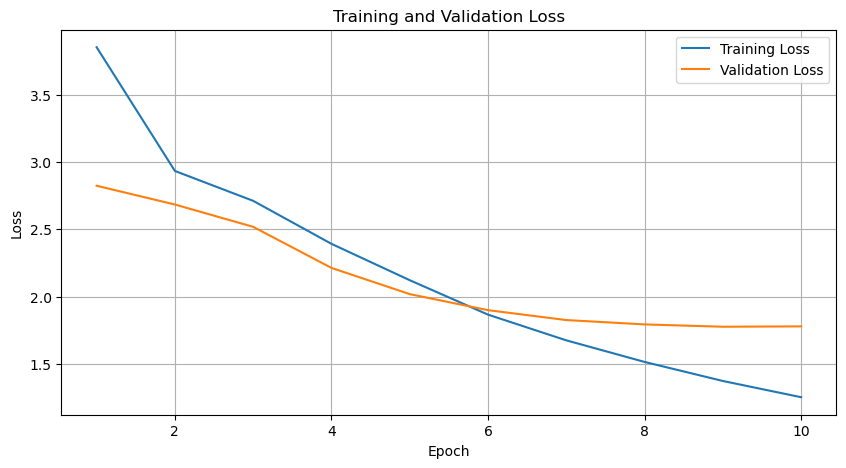

In [24]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, model_params['TRAIN_EPOCHS'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, model_params['TRAIN_EPOCHS'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

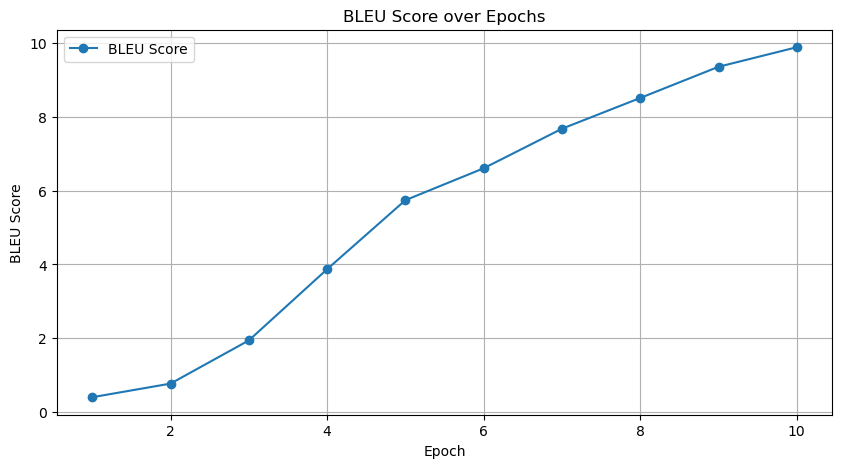

In [25]:
# Plot BLEU Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, model_params['TRAIN_EPOCHS'] + 1), bleu_scores, marker='o', label='BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('BLEU Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

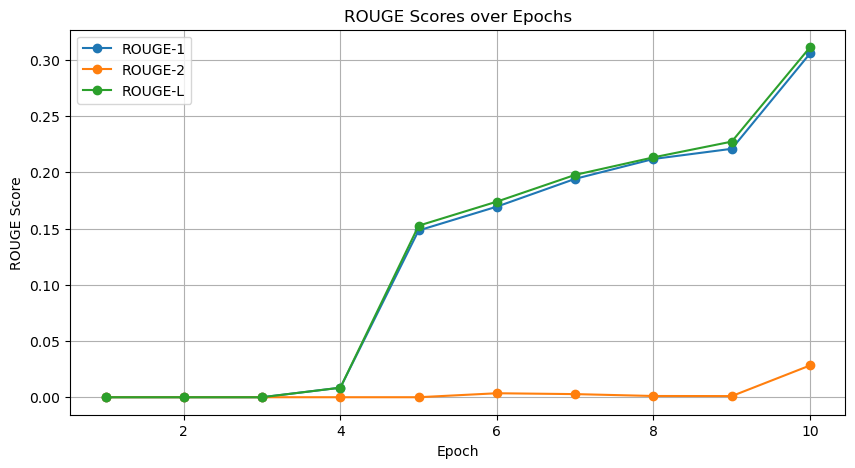

In [26]:
# Plot ROUGE Scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, model_params['TRAIN_EPOCHS'] + 1), rouge1_scores, marker='o', label='ROUGE-1')
plt.plot(range(1, model_params['TRAIN_EPOCHS'] + 1), rouge2_scores, marker='o', label='ROUGE-2')
plt.plot(range(1, model_params['TRAIN_EPOCHS'] + 1), rougeL_scores, marker='o', label='ROUGE-L')
plt.xlabel('Epoch')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores over Epochs')
plt.legend()
plt.grid(True)
plt.show()

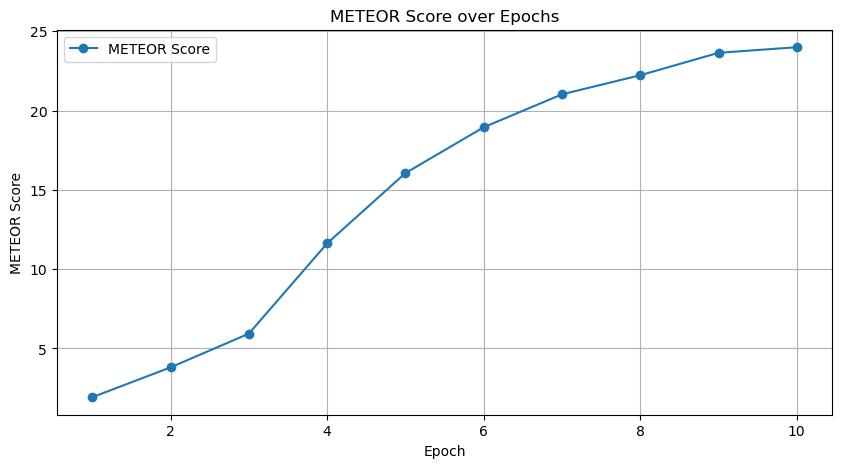

In [27]:
# Plot METEOR Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, model_params['TRAIN_EPOCHS'] + 1), meteor_scores, marker='o', label='METEOR Score')
plt.xlabel('Epoch')
plt.ylabel('METEOR Score')
plt.title('METEOR Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

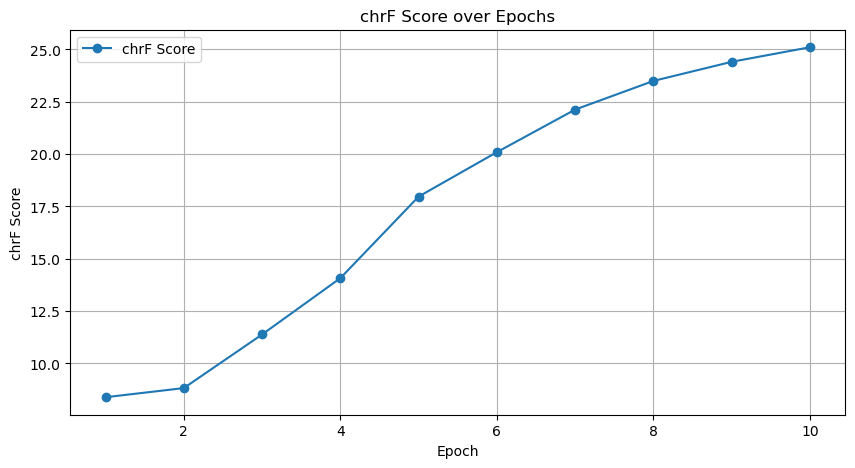

In [28]:
# Plot chrF Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, model_params['TRAIN_EPOCHS'] + 1), chrf_scores, marker='o', label='chrF Score')
plt.xlabel('Epoch')
plt.ylabel('chrF Score')
plt.title('chrF Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Function to generate translation
def generate_translation(text):
    model.eval()
    input_text = task_prefix + text
    input_ids = tokenizer.encode(
        input_text,
        return_tensors='pt',
        max_length=model_params['MAX_SOURCE_TEXT_LENGTH'],
        truncation=True
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            max_length=model_params['MAX_TARGET_TEXT_LENGTH'],
            num_beams=4,
            repetition_penalty=2.5,
            length_penalty=1.0,
            early_stopping=True
        )
    preds = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return preds

In [30]:
# Test the model with a sample input
sample_text = df['darija'].iloc[0]
print(f"Darija input: {sample_text}")
print(f"Expected translation: {df['arabic'].iloc[0]}")
print(f"Model translation: {generate_translation(sample_text)}")

Darija input: homa mkhbbyin chi haja, ana mti99en!
Expected translation: إنهم يختبئون شيئاً ما، أنا متأكد!
Model translation: إنهم يختبئون شيئاً ما، أنا متأكد!


In [102]:
sample_text = ""
print(f"Darija input: {sample_text}")
print(f"Model translation: {generate_translation(sample_text)}")

Darija input: kayn sahd bzf 
Model translation: انها على ما يرام
